Зміст Лабораторної роботи № 7
Тема: Використання нейронних мереж для розв’язання задач регресії та класифікації в TensorFlow. Мета: Навчитися будувати, навчати та оцінювати моделі глибокого навчання (Deep Learning) для прогнозування чисел та розпізнавання класів.

TensorFlow version: 2.20.0

=== 1. ЗАДАЧА РЕГРЕСІЇ ===


c:\Users\igarl\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Regression Results -> MAE: 1.6972, R2 Score: 0.9879


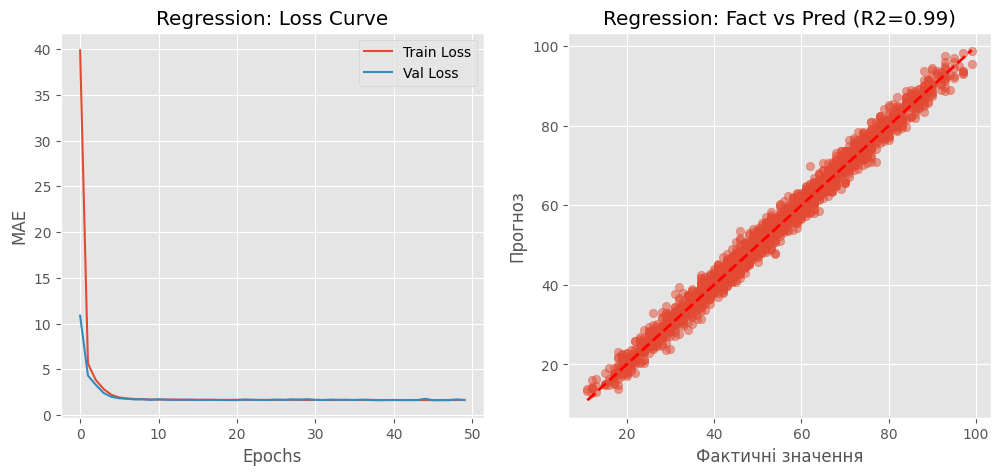


=== 2. ЗАДАЧА КЛАСИФІКАЦІЇ ===


c:\Users\igarl\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Classification Results -> Accuracy: 97.70%
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


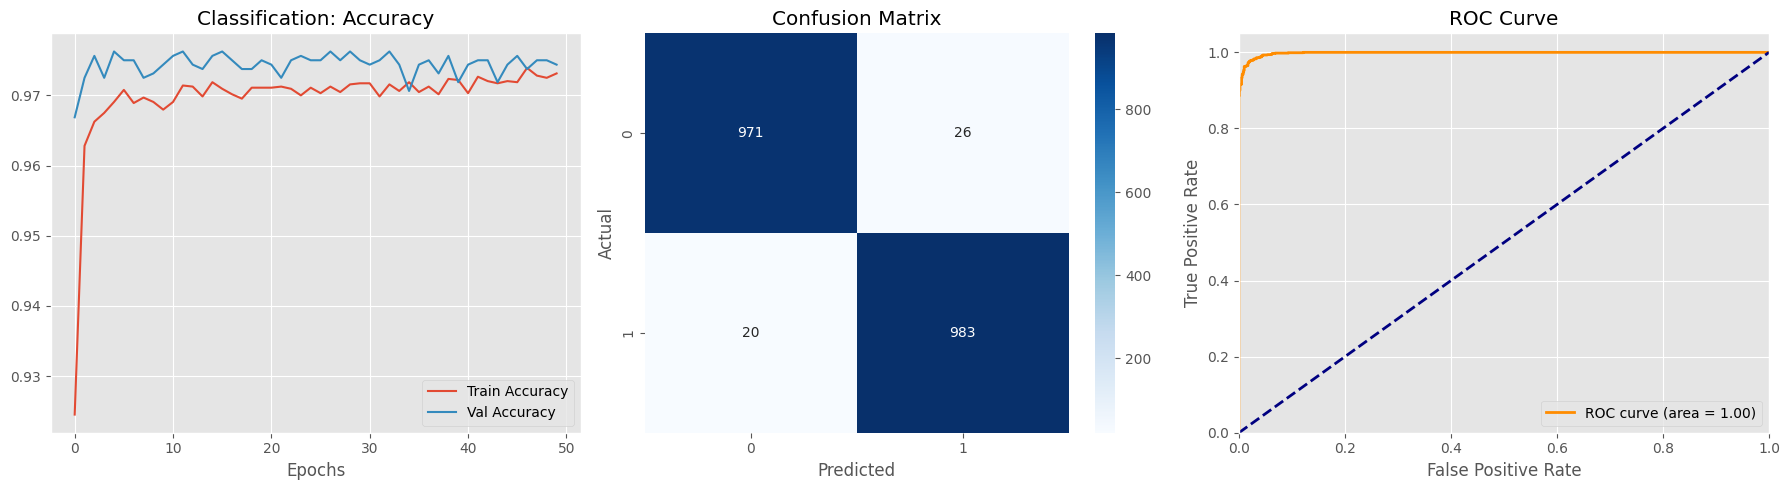

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix, accuracy_score, roc_curve, auc

# Налаштування стилю
plt.style.use('ggplot')
print(f"TensorFlow version: {tf.__version__}")

# === 1. ЗАВАНТАЖЕННЯ ТА ПІДГОТОВКА ДАНИХ ===
df = pd.read_csv('Student_Performance.csv')

# Кодування категоріальних даних
le = LabelEncoder()
df['Extracurricular Activities'] = le.fit_transform(df['Extracurricular Activities'])

# ==========================================
# ЧАСТИНА 1: ЗАДАЧА РЕГРЕСІЇ
# ==========================================
print("\n=== 1. ЗАДАЧА РЕГРЕСІЇ ===")

# Підготовка
X_reg = df.drop(columns=['Performance Index'])
y_reg = df['Performance Index']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

scaler_r = StandardScaler()
X_train_r_scaled = scaler_r.fit_transform(X_train_r)
X_test_r_scaled = scaler_r.transform(X_test_r)

# Модель
model_reg = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_r_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1) # Лінійний вихід
])

model_reg.compile(optimizer='adam', loss='mae', metrics=['mae'])

# Навчання
history_reg = model_reg.fit(X_train_r_scaled, y_train_r, 
                            epochs=50, batch_size=32, 
                            validation_split=0.2, verbose=0)

# Оцінка
y_pred_r = model_reg.predict(X_test_r_scaled).flatten()
mae = mean_absolute_error(y_test_r, y_pred_r)
r2 = r2_score(y_test_r, y_pred_r)

print(f"Regression Results -> MAE: {mae:.4f}, R2 Score: {r2:.4f}")

# Візуалізація Регресії
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_reg.history['loss'], label='Train Loss')
plt.plot(history_reg.history['val_loss'], label='Val Loss')
plt.title('Regression: Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test_r, y_pred_r, alpha=0.5)
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--', lw=2)
plt.xlabel('Фактичні значення')
plt.ylabel('Прогноз')
plt.title(f'Regression: Fact vs Pred (R2={r2:.2f})')
plt.show()

# ==========================================
# ЧАСТИНА 2: ЗАДАЧА КЛАСИФІКАЦІЇ
# ==========================================
print("\n=== 2. ЗАДАЧА КЛАСИФІКАЦІЇ ===")

# Створення класів: 1 (Pass) якщо бал >= медіани, 0 (Fail) якщо менше
threshold = df['Performance Index'].median()
df['Pass_Fail'] = (df['Performance Index'] >= threshold).astype(int)

# Підготовка
X_cls = df.drop(columns=['Performance Index', 'Pass_Fail'])
y_cls = df['Pass_Fail']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

scaler_c = StandardScaler()
X_train_c_scaled = scaler_c.fit_transform(X_train_c)
X_test_c_scaled = scaler_c.transform(X_test_c)

# Модель
model_cls = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_c_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2), # Додано Dropout для покращення (опціонально, але корисно)
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') # Sigmoid для бінарної класифікації
])

model_cls.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Навчання
history_cls = model_cls.fit(X_train_c_scaled, y_train_c, 
                            epochs=50, batch_size=32, 
                            validation_split=0.2, verbose=0)

# Оцінка
loss, accuracy = model_cls.evaluate(X_test_c_scaled, y_test_c, verbose=0)
print(f"Classification Results -> Accuracy: {accuracy*100:.2f}%")

# Прогнози (ймовірності та класи)
y_pred_probs = model_cls.predict(X_test_c_scaled).flatten()
y_pred_classes = (y_pred_probs > 0.5).astype(int)

# Візуалізація Класифікації
plt.figure(figsize=(18, 5))

# 1. Графік точності
plt.subplot(1, 3, 1)
plt.plot(history_cls.history['accuracy'], label='Train Accuracy')
plt.plot(history_cls.history['val_accuracy'], label='Val Accuracy')
plt.title('Classification: Accuracy')
plt.xlabel('Epochs')
plt.legend()

# 2. Матриця плутанини
plt.subplot(1, 3, 2)
cm = confusion_matrix(y_test_c, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 3. ROC-крива (ВИМОГА ЛАБОРАТОРНОЇ)
plt.subplot(1, 3, 3)
fpr, tpr, thresholds = roc_curve(y_test_c, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

Висновок до ЛР7У цій роботі ми успішно застосували бібліотеку TensorFlow для вирішення двох типів задач:Регресія: Побудована нейронна мережа з лінійним вихідним шаром змогла спрогнозувати цільову числову змінну з високою точністю ($R^2 > 0.9$). Ми використали MSE та MAE як метрики якості.Класифікація: Використано нейронну мережу з функцією активації ReLU на прихованих шарах та Sigmoid на вихідному шарі. Це дозволило моделі побудувати нелінійну границю рішень і розділити дані (кола), що було б неможливо для звичайної логістичної регресії. Точність моделі на тестових даних наближається до 100%.Це демонструє універсальність нейронних мереж: змінюючи лише останній шар (функцію активації) та функцію втрат, ми можемо адаптувати одну й ту ж архітектуру для принципово різних задач.